## 3 Sentiment Analysis [40 points]

Sentiment analysis refers to the use of natural language processing to systematically identify, extract, quantify, and study affective states and subjective information. As shown in class it is widely applied to reviews and survey responses, and social media content for applications that range from marketing to customer service. In this problem, we will explore a basic task in sentiment analysis, which is classifying the polarity of a given text to be positive or negative.

For this problem, we will use the training data containing 10,000 Yelp restaurant reviews, where each review is labelled based on their ratings. Reviews for training dataset are in the corresponding folders (‘/neg’ for negative reviews and ‘/pos’ for positive reviews). Label the negative sentiment reviews from the /neg folder as 1 and the positive sentiment reviews from the /pos folder as 0, these 1 and 0 labels will be your target labels for sentiment analysis.

The training data is available at: http://bit.ly/2nuzyUM

You can use the following tools for implementation:
1. TensorFlow https://www.tensorflow.org/
2. Scikit-learn http://scikit-learn.org/stable/index.html
3. PyTorch http://pytorch.org/

In addition to output, results and your answers (in a file named Q3.txt), please submit your code along with a README file explaining how to run your code.

In [1]:
import glob
from sklearn.utils import shuffle
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import string
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Using TensorFlow backend.


In [3]:
def load_data(input_directory):
    filenames = []
    data = []
    labels = []
    for filename in glob.glob(input_directory + "/*"):
#         print("Prepocessing: {}".format(file_name))
        filenames.append(filename[filename.rfind('/')+1:])
        file_pointer = open(filename, "r")

        # Read file contents
        file_content = file_pointer.read()
        data.append(file_content)
        file_pointer.close()
        
    # Get the labels
    if input_directory[input_directory.rfind('/')+1:] == 'neg':
        labels = [1] * len(data)
    else:
        labels = [0] * len(data)
    return filenames, data, labels

In [4]:
negative_filenames, negative_data, negative_labels = load_data('../input/training/neg')
positive_filenames, positive_data, positive_labels = load_data('../input/training/pos')
train_filenames = negative_filenames + positive_filenames
train_data = negative_data + positive_data
train_labels = negative_labels + positive_labels
train_filenames, train_data, train_labels = shuffle(train_filenames, train_data, train_labels, random_state=0)

In [5]:
train_data[0:2]

['By far my favorite lunch spot in the entire Phoenix area. The chopped salad & chicken pesto sandwich are my favorite. The desserts are delicious. Try the lunch special and you get an amazing little chocolate chip cookie!',
 'This place is keeping itself in business by promoting weekly and monthly recurring customers.  They play a video about diseases related to back troubles of which 75% would be thrown away by the American Medical Association. Some chiros will help you. They will not. I was told that one visit does nothing and repeat trips are the only way to get relief.  Nice receptionist, but morally bankrupt premise that their business is built on. Not practice. Business.']

In [18]:
len(train_labels)

10000

#### Support Functions

In [7]:
def get_word_tokens(data):
    # Get word tokens - will include {'can't', 'app.'}
    word_tokens = data.split()
    
    # Create a puntuation table
    table = str.maketrans('', '', string.punctuation)
    
    # Remove puntuations, lowercase the word.
    result = []
    for word_token in word_tokens:
        word_token = word_token.strip()
        if (word_token == None) or (word_token == ''):
            continue
        elif word_token in string.punctuation:
            # ",", "."
            continue
        else:
            # For words like "app." --> "app" | "man --> man"
            word_token = word_token.translate(table)
            # Lowercase the word
            word_token = word_token.lower()
        result.append(word_token)
        
    return result

In [8]:
def generate_ngrams(word_tokens, n):
    ngrams_zip = zip(*[word_tokens[i:] for i in range(n)])
    ngrams_list = [" ".join(element) for element in ngrams_zip]
    ngrams_keys_counts = Counter(ngrams_list)
    return ngrams_keys_counts

In [9]:
def get_vocab(filenames, data):
    vocab = {}
    file_vocab = {}
    for i in range(len(data)):
        
        # Get word tokens
        word_tokens = get_word_tokens(data[i])
        unigram_key_counts = generate_ngrams(word_tokens, 1)
        
        file_vocab[filenames[i]] = {
            'doc_length': len(word_tokens),
            'tf': dict(unigram_key_counts)
        }
        
        for word, counts in unigram_key_counts.items():
            if word in vocab:
                vocab[word] = {'ttf': vocab[word]['ttf'] + counts, 'df': vocab[word]['df'] + 1}
            else:
                vocab[word] = {'ttf': counts, 'df': 1}
    return vocab, file_vocab

In [10]:
def get_cross_validation_sets(k, train_df):
    result = []
    size = train_df.shape[0]
    each_dev_set_size = int(size/k)
    for i in range(0, size, each_dev_set_size):
        if i == 0:
            result.append({
                'dev': (i, i+each_dev_set_size),
                'train': (i+each_dev_set_size, size),
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': train_df.iloc[i+each_dev_set_size:size, :]
            })
        elif (i + each_dev_set_size) == size:
            result.append({
                'dev':(i, i+each_dev_set_size),
                'train': (0, i),
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': train_df.iloc[0:i, :]
            })
        else:
            temp_train_df_1 = train_df.iloc[0:i, :]
            temp_train_df_2 = train_df.iloc[i+each_dev_set_size:size, :]
            temp_train_df = pd.concat([temp_train_df_1, temp_train_df_2])
            result.append({
                'dev':(i, i+each_dev_set_size),
                'train': [(0, i), (i+each_dev_set_size, size)],
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': temp_train_df
            })
            
    return result

In [11]:
def plot_accuracy(history):
    # Plotting the history of accuracy 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()

In [12]:
def plot_loss(history):
    # Summarizing the history of loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()

In [13]:
def get_model_template(input_dimensions, n1, activation_function):
    model = Sequential()
    model.add(Dense(n1, input_dim=input_dimensions, activation=activation_function))
    model.add(Dense(10, activation=activation_function))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
def train(model, x_train, y_train, x_test=None, y_test=None, save=False, model_name=None):
    model.summary()
    history = None
    if x_test is None:
        ## If validation/test set is not given
        print("Validation/Test set is not given")
        history = model.fit(x_train, y_train, epochs=10, batch_size=64)
    else:
        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)
    
    if save == True:
        model.save('../output/'+model_name+'.h5')
    return model, history

In [15]:
def get_x_y(df):
    x = df[df.columns.difference(['y_label', 'filenameindex'])].values
    y = df[['y_label']].values
    return x,y

In [16]:
def get_parameters(cross_validation_sets, output_filename, neurons_in_layer_1, activation_functions):
    temp_output_file = open(output_filename, 'w')
    temp_output_file.write('############################## \n\n\n')
    input_dimensions = cross_validation_sets[0]['train_df'].shape[1] - 2
    
    max_val_accuracy = 0
    selected_model_parameters = ()
    for n1 in neurons_in_layer_1:
        for activation_function in activation_functions:
            print('Input Dim: {}, n1: {}, n2: {}, activation: {}, activation_output: {} \n'.format(input_dimensions, n1, 10, activation_function, 'sigmoid'))
            temp_output_file.write('Input Dim: {}, n1: {}, n2: {}, activation: {}, activation_output: {} \n'.format(input_dimensions, n1, 10, activation_function, 'sigmoid'))
            cv_val_accuracy_list = []
            for i in range(len(cross_validation_sets)):
                cross_validation_set = cross_validation_sets[i]

                temp_output_file.write('Dev: {}, Trian: {}\n'.format(cross_validation_set['dev'], cross_validation_set['train']))
                print("Dev: {}, Train: {}".format(cross_validation_set['dev'], cross_validation_set['train']))

                train_df = cross_validation_set['train_df']
                train_x_df, train_y_df = get_x_y(train_df)
                dev_df = cross_validation_set['dev_df']
                dev_x_df, dev_y_df = get_x_y(dev_df)
                
                model = get_model_template(train_x_df.shape[1], n1, activation_function)
                model, history = train(model, train_x_df, train_y_df, dev_x_df, dev_y_df)
                plot_accuracy(history)
                plot_loss(history)
                              
                temp_output_file.write('Accuracy -- Dev: {}, Trian: {}\n'.format(history.history['val_accuracy'][-1], history.history['accuracy'][-1]))
                
                cv_val_accuracy_list.append(history.history['val_accuracy'][-1])
                
            mean_avg = sum(cv_val_accuracy_list) / len(cv_val_accuracy_list)
            temp_output_file.write('Accuracy ---- list: {}, mean: {}\n\n'.format(cv_val_accuracy_list, mean_avg))
            
            # Checking for best parameter
            if mean_avg > max_val_accuracy:
                max_val_accuracy = mean_avg
                selected_model_parameters = {
                    'val_accuracy':max_val_accuracy,
                    'n1': n1,
                    'n2': 10,
                    'activation': activation_function,
                    'n2_activation': 'sigmoid'
                }
     
    temp_output_file.write('Selected parameters: {}\n\n'.format(selected_model_parameters))
    temp_output_file.close()                              
    return selected_model_parameters                        

### 3.1 [10 points]

Train a Multilayer Perceptron (MLP) to predict sentiment score using unigram features (e.g. word counts or one hot encoding of words) as input. You can use the training and testing functions for the MLP from the tool of your choice. You are not required to implement the learning algorithm (i.e., back-propagation) for this problem. Your MLP should have an input layer, two hidden layers, and an output layer; the second hidden layer should have 10 nodes. Use 10-fold cross-validation to optimize any parameters (e.g. activation function or number of nodes in the first hidden layer).
Use accuracy as the metric for parameter selection. Describe your parameter optimization process, and report the parameters of your best model.

Note: Implement the 10-fold cross validation and unigram features without using any library

In [27]:
def run_3_1(train_filenames, train_data, train_labels):

    # Get vocab
    vocab, file_vocab = get_vocab(train_filenames, train_data)
    print("Size of vocab: {}".format(len(vocab)))

    # Create the train dataframe
    train_df = pd.DataFrame(0, index=range(0, len(train_data)), columns = list(vocab.keys())) 
    for i in range(len(train_data)):
        if i % 500 == 0:
            print("Processing row: {}".format(i))
        # Get unigrams for the review
        file_vocab_entry = file_vocab[train_filenames[i]]
        for word, count in file_vocab_entry['tf'].items():
            train_df.iloc[i][word] = count
    train_df['y_label'] = train_labels
    train_df['filenameindex'] = train_filenames
    print(train_df.shape)
    
    cross_validation_sets = get_cross_validation_sets(10, train_df)
    
    output_filename = '../output/mlp_training.txt'
    activation_functions = ['relu', 'sigmoid', 'tanh']
    neurons_in_layer_1 = [2]
    
    selected_model_parameters = get_parameters(cross_validation_sets, output_filename, neurons_in_layer_1, activation_functions)
    return selected_model_parameters

Size of vocab: 27884
Processing row: 0
Processing row: 500
Processing row: 1000
Processing row: 1500
Processing row: 2000
Processing row: 2500
Processing row: 3000
Processing row: 3500
Processing row: 4000
Processing row: 4500
Processing row: 5000
Processing row: 5500
Processing row: 6000
Processing row: 6500
Processing row: 7000
Processing row: 7500
Processing row: 8000
Processing row: 8500
Processing row: 9000
Processing row: 9500
(10000, 27886)
Input Dim: 27884, n1: 2, n2: 10, activation: relu, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 55770     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dens

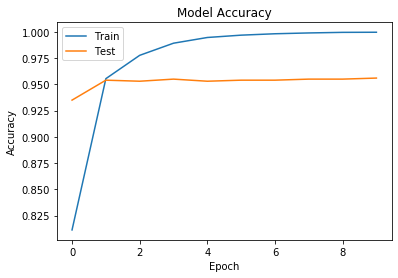

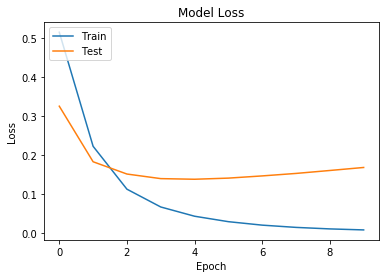

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 55770     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.4690 - accuracy: 0.8518 - val_loss: 0.2923 - val_accuracy: 0.9260
Epoch 2/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.1757 - accuracy: 0.9613 - val_loss: 0.1883 - val_accura

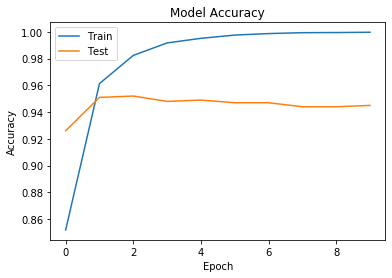

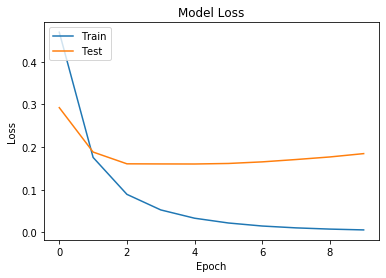

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 55770     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.5615 - accuracy: 0.7824 - val_loss: 0.4641 - val_accuracy: 0.8930
Epoch 2/10
9000/9000 [==============================] - 10s 1ms/step - loss: 0.3786 - accuracy: 0.9467 - val_loss: 0.3484 - val_accura

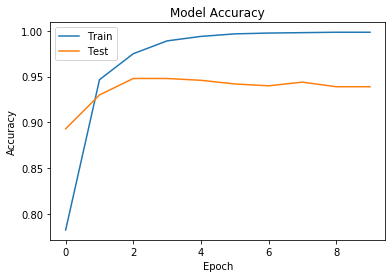

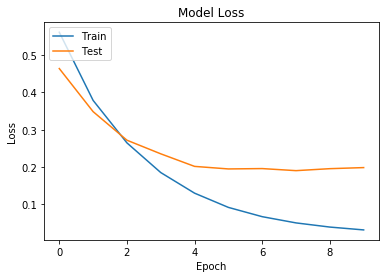

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.6300 - accuracy: 0.7528 - val_loss: 0.5168 - val_accuracy: 0.8600
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.4160 - accuracy: 0.9209 - val_loss: 0.3483 - val_accura

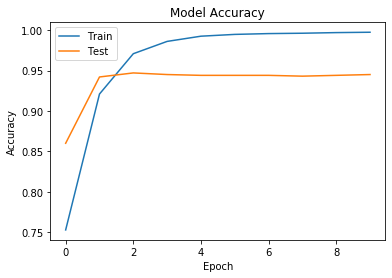

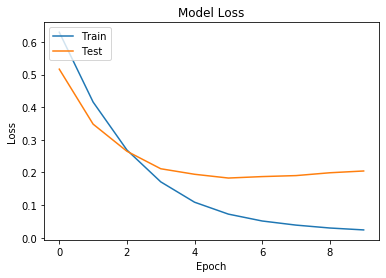

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.5280 - accuracy: 0.7608 - val_loss: 0.3117 - val_accuracy: 0.9240
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.1967 - accuracy: 0.9551 - val_loss: 0.1835 - val_accura

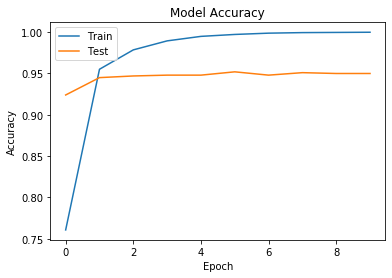

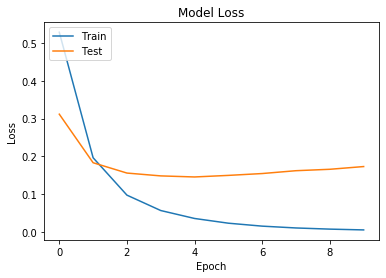

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.5544 - accuracy: 0.8481 - val_loss: 0.3669 - val_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.2339 - accuracy: 0.9520 - val_loss: 0.1842 - val_accura

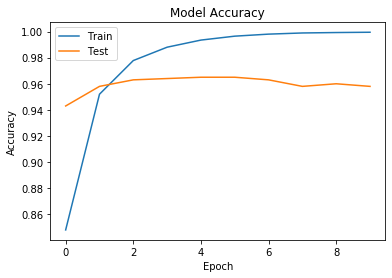

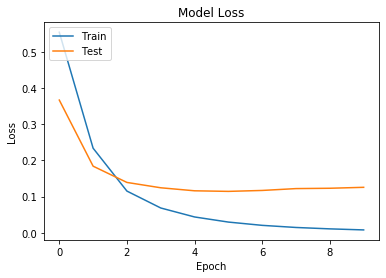

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.6244 - accuracy: 0.6902 - val_loss: 0.5286 - val_accuracy: 0.8730
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.4428 - accuracy: 0.9100 - val_loss: 0.4051 - val_accura

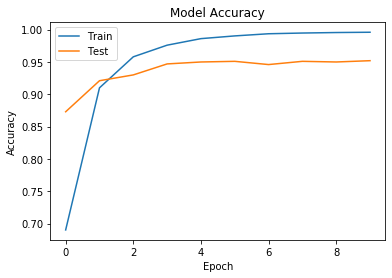

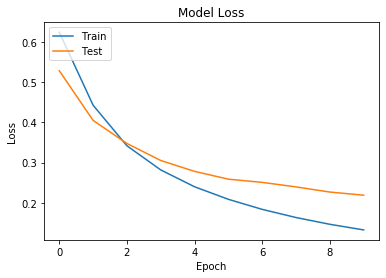

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.5749 - accuracy: 0.7571 - val_loss: 0.4658 - val_accuracy: 0.9110
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.3842 - accuracy: 0.9408 - val_loss: 0.3435 - val_accura

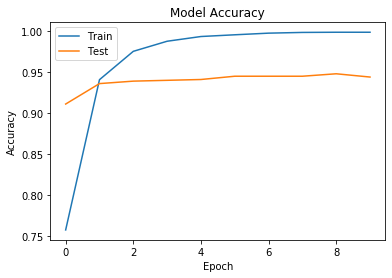

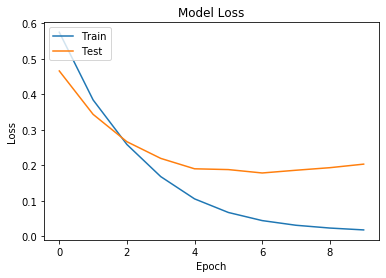

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 14s 2ms/step - loss: 0.5466 - accuracy: 0.8182 - val_loss: 0.4277 - val_accuracy: 0.9260
Epoch 2/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.3344 - accuracy: 0.9514 - val_loss: 0.3139 - val_accura

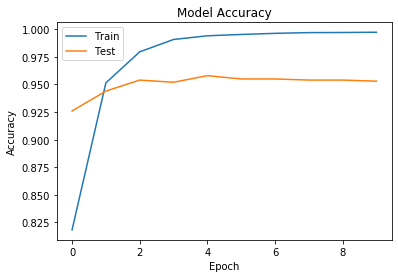

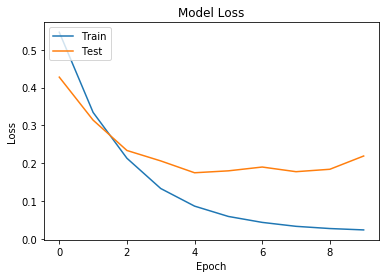

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_29 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.5665 - accuracy: 0.7627 - val_loss: 0.4446 - val_accuracy: 0.9190
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.3621 - accuracy: 0.9461 - val_loss: 0.3135 - val_accuracy: 0.9390
Epoc

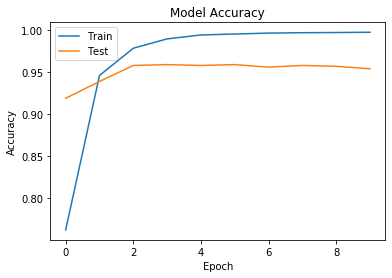

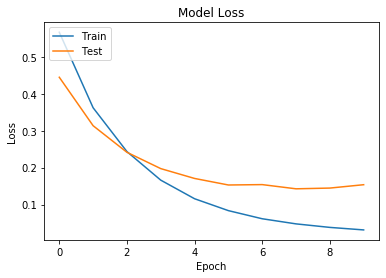

Input Dim: 27884, n1: 2, n2: 10, activation: sigmoid, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_32 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.6804 - accuracy: 0.7444 - val_loss: 0.6545 - val_accuracy: 0.9020
Epoch 2/10
9000/9000 [==============================] - 13s 1ms/st

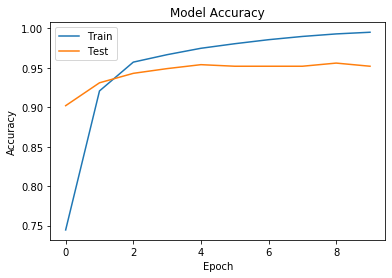

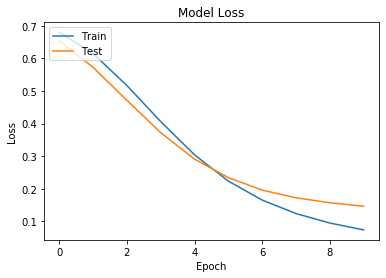

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 14s 2ms/step - loss: 0.6946 - accuracy: 0.5009 - val_loss: 0.6813 - val_accuracy: 0.6000
Epoch 2/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.6515 - accuracy: 0.9170 - val_loss: 0.6199 - val_accur

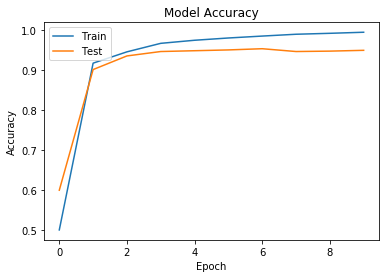

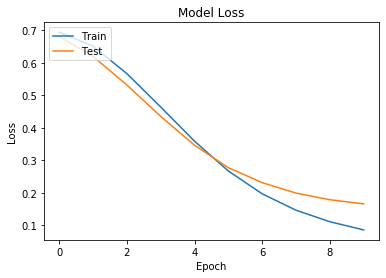

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_38 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.6877 - accuracy: 0.5808 - val_loss: 0.6612 - val_accuracy: 0.8670
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.6244 - accuracy: 0.9130 - val_loss: 0.5930 - val_accur

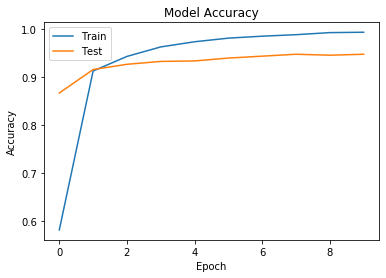

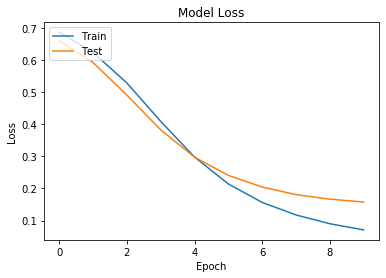

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_41 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6764 - accuracy: 0.6651 - val_loss: 0.6408 - val_accuracy: 0.9040
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.5922 - accuracy: 0.9139 - val_loss: 0.5462 - val_accur

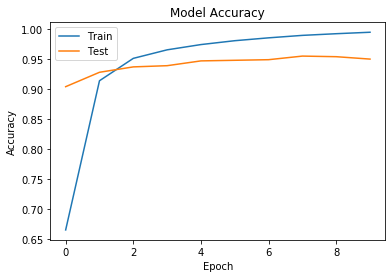

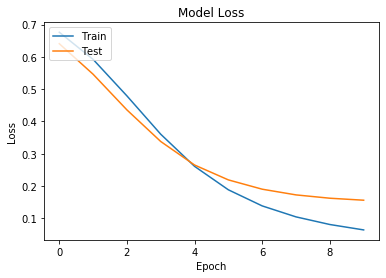

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_44 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.7603 - accuracy: 0.4988 - val_loss: 0.6999 - val_accuracy: 0.5110
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6734 - accuracy: 0.5174 - val_loss: 0.6337 - val_accur

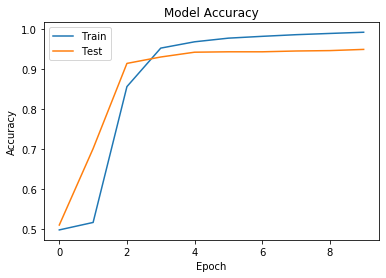

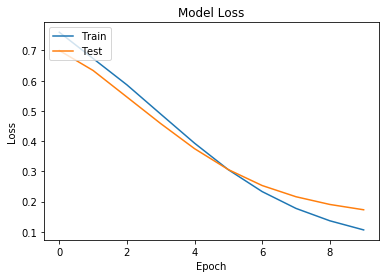

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_47 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6792 - accuracy: 0.6467 - val_loss: 0.6529 - val_accuracy: 0.8710
Epoch 2/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.6137 - accuracy: 0.9047 - val_loss: 0.5730 - val_accur

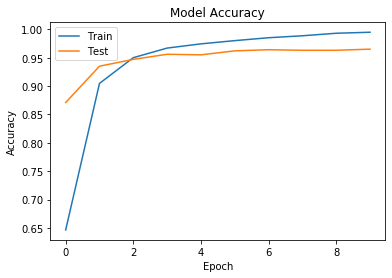

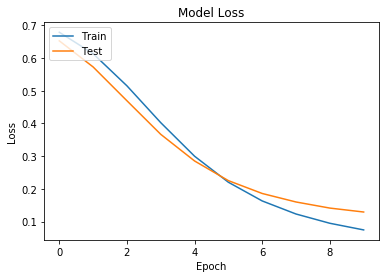

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_50 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.6614 - accuracy: 0.7320 - val_loss: 0.6213 - val_accuracy: 0.9120
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.5757 - accuracy: 0.9352 - val_loss: 0.5303 - val_accur

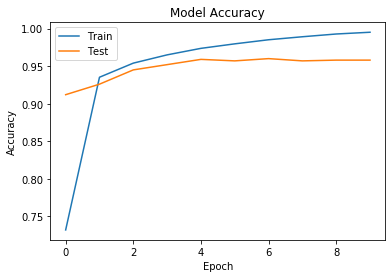

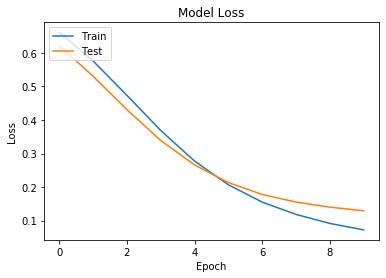

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_53 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6996 - accuracy: 0.5044 - val_loss: 0.6692 - val_accuracy: 0.5810
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6293 - accuracy: 0.8780 - val_loss: 0.5939 - val_accur

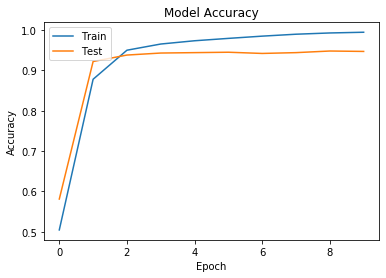

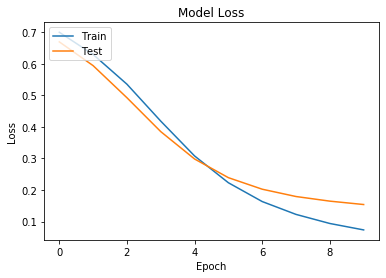

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_56 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6719 - accuracy: 0.7482 - val_loss: 0.6401 - val_accuracy: 0.9000
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.5932 - accuracy: 0.9241 - val_loss: 0.5450 - val_accur

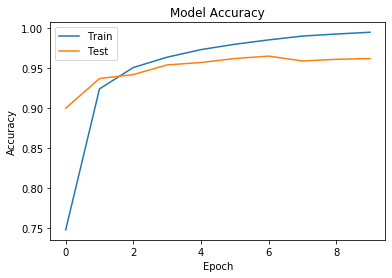

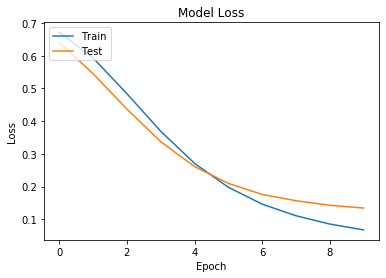

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_59 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6657 - accuracy: 0.7622 - val_loss: 0.6314 - val_accuracy: 0.9030
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.5843 - accuracy: 0.9308 - val_loss: 0.5352 - val_accuracy: 0.9370
Epoc

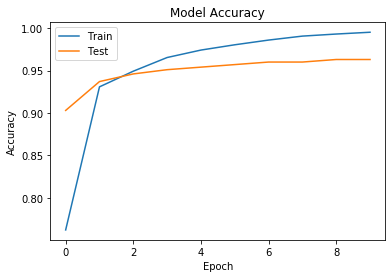

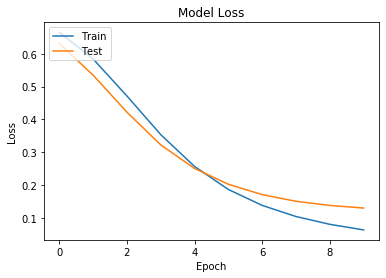

Input Dim: 27884, n1: 2, n2: 10, activation: tanh, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_62 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.4213 - accuracy: 0.8740 - val_loss: 0.2389 - val_accuracy: 0.9400
Epoch 2/10
9000/9000 [==============================] - 10s 1ms/step 

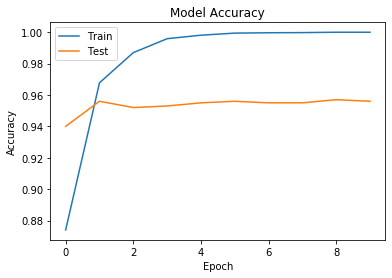

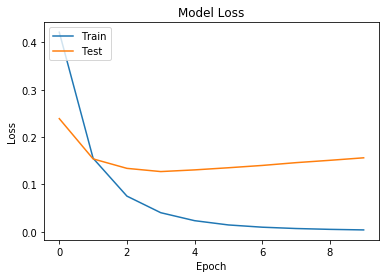

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_65 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.5114 - accuracy: 0.8632 - val_loss: 0.3383 - val_accuracy: 0.9300
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2154 - accuracy: 0.9603 - val_loss: 0.1988 - val_accur

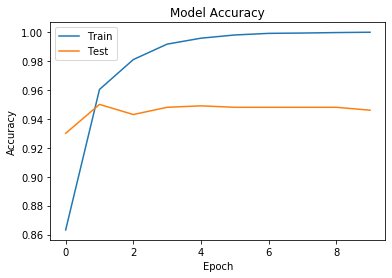

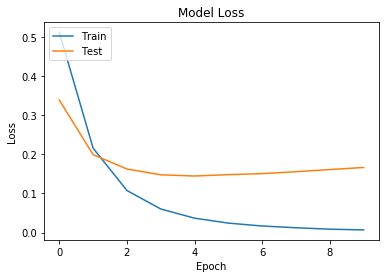

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_68 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.4394 - accuracy: 0.8811 - val_loss: 0.2815 - val_accuracy: 0.9260
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.1692 - accuracy: 0.9672 - val_loss: 0.1791 - val_accur

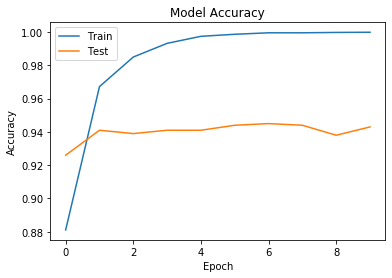

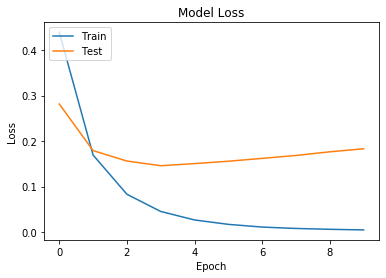

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_71 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.5201 - accuracy: 0.8504 - val_loss: 0.3488 - val_accuracy: 0.9300
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2210 - accuracy: 0.9610 - val_loss: 0.1914 - val_accur

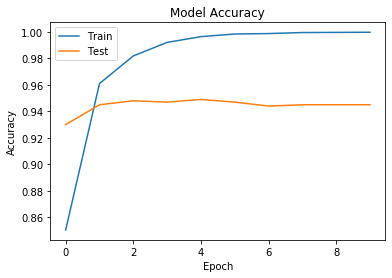

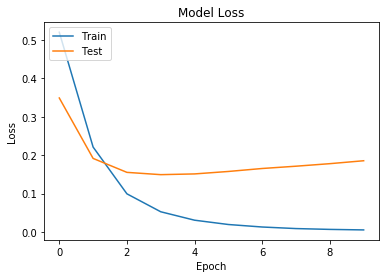

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_74 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.5214 - accuracy: 0.8696 - val_loss: 0.3399 - val_accuracy: 0.9310
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2175 - accuracy: 0.9612 - val_loss: 0.1916 - val_accur

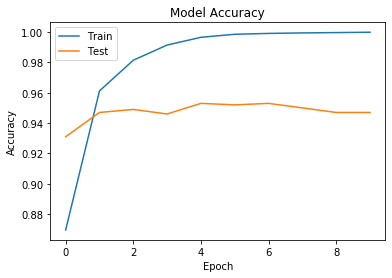

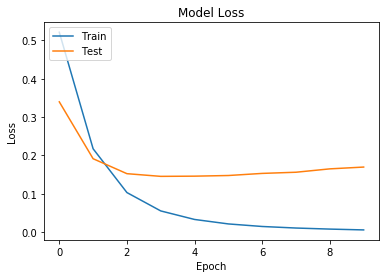

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_77 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.4879 - accuracy: 0.8718 - val_loss: 0.3034 - val_accuracy: 0.9370
Epoch 2/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.1955 - accuracy: 0.9624 - val_loss: 0.1617 - val_accur

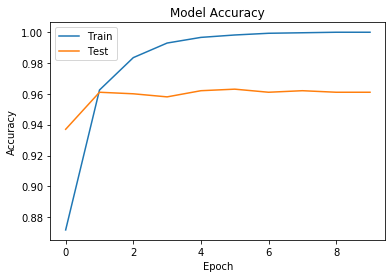

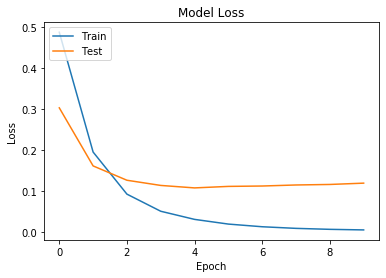

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_80 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 16s 2ms/step - loss: 0.4920 - accuracy: 0.8653 - val_loss: 0.3018 - val_accuracy: 0.9440
Epoch 2/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.2003 - accuracy: 0.9624 - val_loss: 0.1740 - val_accur

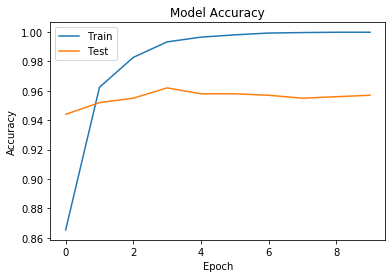

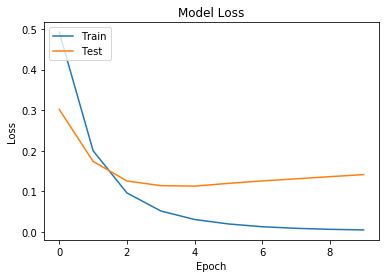

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_83 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.4803 - accuracy: 0.8563 - val_loss: 0.2905 - val_accuracy: 0.9260
Epoch 2/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.1816 - accuracy: 0.9627 - val_loss: 0.1699 - val_accur

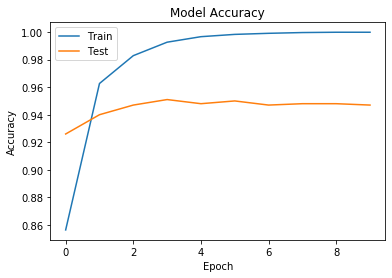

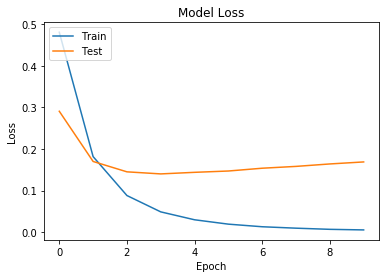

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_86 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.4284 - accuracy: 0.8729 - val_loss: 0.2538 - val_accuracy: 0.9370
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.1646 - accuracy: 0.9637 - val_loss: 0.1570 - val_accur

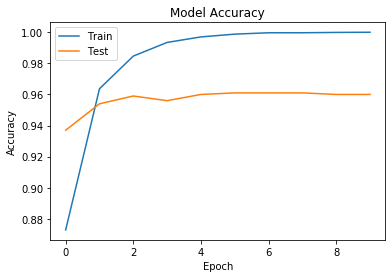

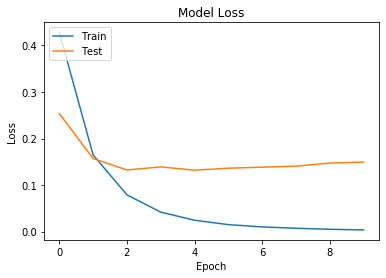

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_89 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 12s 1ms/step - loss: 0.4886 - accuracy: 0.8613 - val_loss: 0.2936 - val_accuracy: 0.9410
Epoch 2/10
9000/9000 [==============================] - 11s 1ms/step - loss: 0.1958 - accuracy: 0.9616 - val_loss: 0.1668 - val_accuracy: 0.9590
Epoc

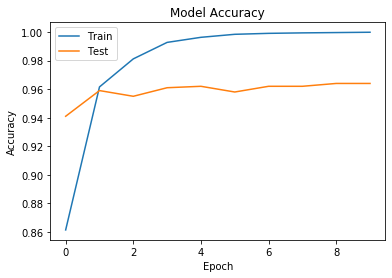

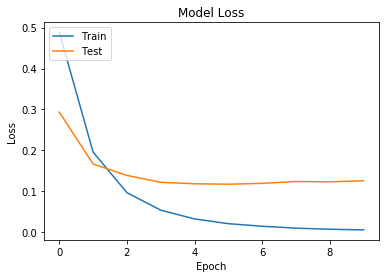

In [28]:
mlp_selected_model_parameters = run_3_1(train_filenames, train_data, train_labels)

### 3.2 [2 points]
Using the parameters for the best performing model from 3.1, re-train the model on the whole training set, and report the accuracy on the same training set. (This tells you how the selected model performs on the full training data.)

In [29]:
mlp_selected_model_parameters = selected_model_parameters

In [33]:
def run_3_2(train_data, selected_model_parameters):
    # Get vocab
    vocab, file_vocab = get_vocab(train_filenames, train_data)
    print("Size of vocab: {}".format(len(vocab)))

    # Create the train dataframe
    train_df = pd.DataFrame(0, index=range(0, len(train_data)), columns = list(vocab.keys())) 
    for i in range(len(train_data)):
        if i % 500 == 0:
            print("Processing row: {}".format(i))
        # Get unigrams for the review
        file_vocab_entry = file_vocab[train_filenames[i]]
        for word, count in file_vocab_entry['tf'].items():
            train_df.iloc[i][word] = count
    train_df['y_label'] = train_labels
    train_df['filenameindex'] = train_filenames
    print(train_df.shape)
    
    temp_output_file = open('../output/mlp_result.txt', 'w')
    temp_output_file.write('Selected Parameters: {}\n\n'.format(selected_model_parameters))
    train_x_df, train_y_df = get_x_y(train_df)
    model = get_model_template(train_x_df.shape[1], selected_model_parameters['n1'], selected_model_parameters['activation'])
    model, history = train(model, train_x_df, train_y_df, None, None, True, 'mlp')
    temp_output_file.write('Train Accuracy: {}\n\n'.format(history.history['accuracy'][-1]))

In [34]:
run_3_2(train_data, mlp_selected_model_parameters)

Size of vocab: 27884
Processing row: 0
Processing row: 500
Processing row: 1000
Processing row: 1500
Processing row: 2000
Processing row: 2500
Processing row: 3000
Processing row: 3500
Processing row: 4000
Processing row: 4500
Processing row: 5000
Processing row: 5500
Processing row: 6000
Processing row: 6500
Processing row: 7000
Processing row: 7500
Processing row: 8000
Processing row: 8500
Processing row: 9000
Processing row: 9500
(10000, 27886)
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 2)                 55770     
_________________________________________________________________
dense_92 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 11        
Total params: 55,811
Trainable params: 55,811
Non-trainable par